In [2]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from shapely.geometry import LineString, Point

In [ ]:
'''

This script is meant to take in data exported from OVITO and analyze the displaced particles, count the number of vacancies
present within the crystal sample, measure the track length, calculate the theoretical vacancy density as a function of 
depth into the crystal, and find the track width as a function of track depth into the sample. 

This notebook is a continuous work in progress, and especially the proposed methodology to find the track width may need \
to be modified in the future.

Currently to calculate the number of vacancies we say that it is a 1:1 relationship with the number of displaced atoms, which 
is what we are specifically examining in the code below. 

To find the vacancy density as a function of depth, we take volume slices perpendicular to the direction of the inbound gold
ion and count the number of vacancies in this rectangular region over many different depth options. The starting and ending
points of these rectangles are easily modifiable by changing the starting and ending values in the function input.

To find the track width, we first specify along which axis we want to find the track width and then about the 0-point which the
gold ion was initially shot in on (for example at x = 0 or x = 10 or y = 20) for a particular depth we do a complete 360 degree
rotation about the other two axes and find the atoms which have the shortest radius at that particular point (with a specified 
small tolerance value). The values returned are the predicted radii, so we multiply the answer by 2 in the final plot.

***This is open to being modified since this was a rudimentary idea.***

@author: kmream


'''

### Step 1: Get Data Loaded and Visualized

In [3]:
#data_1 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_50000_5pico', sep = " ").sort_values(by = 'id')
data_1 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_50000_5pico', sep = " ").sort_values(by = 'id')
data_2 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_46313_11pico', sep = " ").sort_values(by = 'id')
data_3 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_40000_5pico', sep = " ").sort_values(by = 'id')
data_4 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_15000_5pico', sep = " ").sort_values(by = 'id')
data_5 = pd.read_csv('5_25_2025_runs/5_25_2025_gold_silicon_elecstop_4pico', sep = " ").sort_values(by = 'id')

seeds = ['50000', '46313', '40000', '15000', '10000']

data_1['x'], data_2['x'], data_3['x'], data_4['x'], data_5['x'] = data_1['x'].values / 10, data_2['x'].values / 10, data_3['x'].values / 10, data_4['x'].values / 10, data_5['x'].values / 10
data_1['y'], data_2['y'], data_3['y'], data_4['y'], data_5['y'] = data_1['y'].values / 10, data_2['y'].values / 10, data_3['y'].values / 10, data_4['y'].values / 10, data_5['y'].values / 10
data_1['z'], data_2['z'], data_3['z'], data_4['z'], data_5['z'] = data_1['z'].values / 10, data_2['z'].values / 10, data_3['z'].values / 10, data_4['z'].values / 10, data_5['z'].values / 10
steps1, steps2, steps3, steps4, steps5 = np.unique(data_1['step'].values), np.unique(data_2['step'].values), np.unique(data_3['step'].values), np.unique(data_4['step'].values), np.unique(data_5['step'].values)

In [4]:
data_5

,id,type,x,y,z,coordination,step
0,439802,1,11.8528,27.1128,12.5478,0.908740,8600.0
1,439810,1,11.8445,27.1543,13.0865,1.014815,8600.0
2,457801,1,11.9202,23.9961,12.1912,4.882507,8600.0
3,457802,1,12.2488,24.4524,12.5339,1.275239,8600.0
4,459403,1,12.2803,26.2483,12.9535,1.216088,8600.0
...,...,...,...,...,...,...,...
182,539820,1,14.2092,27.1510,14.0595,0.929000,8600.0
183,559794,1,15.1183,27.1553,12.0251,0.833344,8600.0
184,559807,1,14.7224,27.0883,13.2549,1.050415,8600.0
185,559810,1,15.1539,27.1158,13.0991,0.984492,8600.0


### Visualize the damage, comparing different parameters or seeds against one another.

(12.0251, 14.5886)

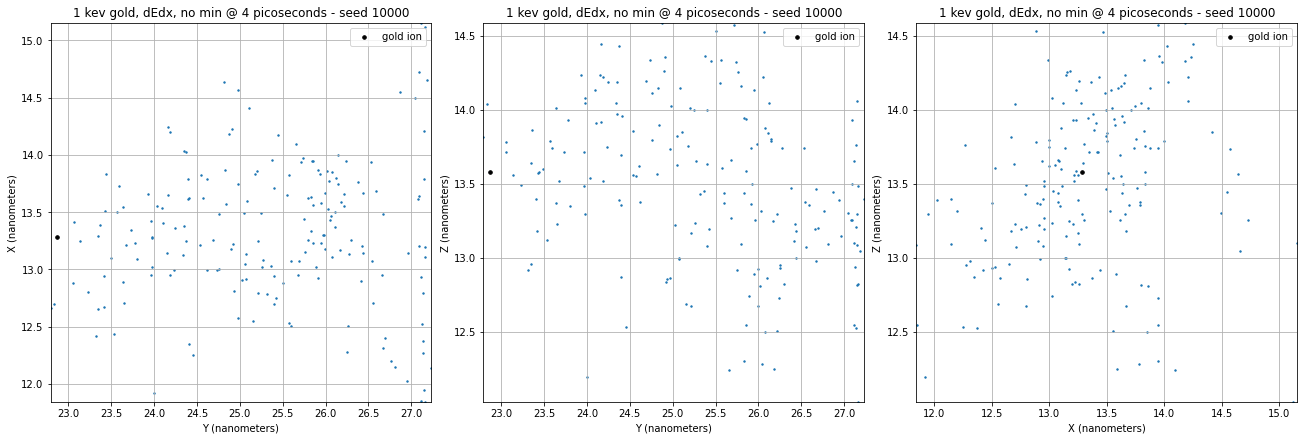

In [5]:
# Original data
kev = 1
num_sec = 4
data_list = [data_1, data_2, data_3, data_4, data_5]

dataframe = 5
data = data_list[dataframe - 1]

gold_type = 2

x_min, x_max = data['x'].min(), data['x'].max()
y_min, y_max = data['y'].min(), data['y'].max()
z_min, z_max = data['z'].min(), data['z'].max()

#x_min, x_max = data_5['x'].min(), data_5['x'].max()
#y_min, y_max = data_5['y'].min(), data_5['y'].max()
#z_min, z_max = data_5['z'].min(), data_5['z'].max()

######################################################################################

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

axes[0].scatter(data['y'].values, data['x'].values, s = 8, marker = '.')
axes[0].scatter(data[data['type'] == gold_type]['y'].values, data[data['type'] == gold_type]['x'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[0].set_title(f'{kev} kev gold, dEdx, no min @ {num_sec} picoseconds - seed {seeds[dataframe-1]}')
axes[0].set_xlabel('Y (nanometers)')
axes[0].set_ylabel('X (nanometers)')
axes[0].legend(loc = 'best')
axes[0].grid(True)
axes[0].set_xlim(y_min, y_max)
axes[0].set_ylim(x_min, x_max)

axes[1].scatter(data['y'].values, data['z'].values, s = 8, marker = '.')
axes[1].scatter(data[data['type'] == gold_type]['y'].values, data[data['type'] == gold_type]['z'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[1].set_title(f'{kev} kev gold, dEdx, no min @ {num_sec} picoseconds - seed {seeds[dataframe-1]}')
axes[1].set_xlabel('Y (nanometers)')
axes[1].set_ylabel('Z (nanometers)')
axes[1].legend(loc = 'best')
axes[1].grid(True)
axes[1].set_xlim(y_min, y_max)
axes[1].set_ylim(z_min, z_max)

axes[2].scatter(data['x'].values, data['z'].values, s = 8, marker = '.')
axes[2].scatter(data[data['type'] == gold_type]['x'].values, data[data['type'] == gold_type]['z'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[2].set_title(f'{kev} kev gold, dEdx, no min @ {num_sec} picoseconds - seed {seeds[dataframe-1]}')
axes[2].set_xlabel('X (nanometers)')
axes[2].set_ylabel('Z (nanometers)')
axes[2].legend(loc = 'best')
axes[2].grid(True)
axes[2].set_xlim(x_min, x_max)
axes[2].set_ylim(z_min, z_max)

### Step 3: Quantify number of vacancies and calculate approximate track length.

In [6]:
num_vacancies1 = [len(data_1[data_1['step'] == step]) for step in steps1]
num_vacancies2 = [len(data_2[data_2['step'] == step]) for step in steps2]
num_vacancies3 = [len(data_3[data_3['step'] == step]) for step in steps3]
num_vacancies4 = [len(data_4[data_4['step'] == step]) for step in steps4]
num_vacancies5 = [len(data_5[data_5['step'] == step]) for step in steps5]

####################################################################################################

print(f'For seed {seeds[0]} without dEdX electronic there were {num_vacancies1} vacancies')
print(f'For seed {seeds[1]} without dEdX electronic there were {num_vacancies2} vacancies')
print(f'For seed {seeds[2]} without dEdX electronic there were {num_vacancies3} vacancies')
print(f'For seed {seeds[3]} without dEdX electronic there were {num_vacancies4} vacancies')
print(f'For seed {seeds[4]} with dEdX electronic and without initial minimization there were {num_vacancies5} vacancies')

For seed 50000 without dEdX electronic there were [1243] vacancies
For seed 46313 without dEdX electronic there were [1323] vacancies
For seed 40000 without dEdX electronic there were [1271] vacancies
For seed 15000 without dEdX electronic there were [1306] vacancies
For seed 10000 with dEdX electronic and without initial minimization there were [187] vacancies


### Step 4: Find vacancy density in one specific region

In [7]:
# units of dimensions are in angstroms
x_len1 = np.max(data_1['x'].values) - np.min(data_1['x'].values)
y_len1 = np.max(data_1['y'].values) - np.min(data_1['y'].values)
z_len1 = np.max(data_1['z'].values) - np.min(data_1['z'].values)

x_len2 = np.max(data_2['x'].values) - np.min(data_2['x'].values)
y_len2 = np.max(data_2['y'].values) - np.min(data_2['y'].values)
z_len2 = np.max(data_2['z'].values) - np.min(data_2['z'].values)

x_len3 = np.max(data_3['x'].values) - np.min(data_3['x'].values)
y_len3 = np.max(data_3['y'].values) - np.min(data_3['y'].values)
z_len3 = np.max(data_3['z'].values) - np.min(data_3['z'].values)

x_len4 = np.max(data_4['x'].values) - np.min(data_4['x'].values)
y_len4 = np.max(data_4['y'].values) - np.min(data_4['y'].values)
z_len4 = np.max(data_4['z'].values) - np.min(data_4['z'].values)

x_len5 = np.max(data_5['x'].values) - np.min(data_5['x'].values)
y_len5 = np.max(data_5['y'].values) - np.min(data_5['y'].values)
z_len5 = np.max(data_5['z'].values) - np.min(data_5['z'].values)

volume1, volume2 = ((x_len1) * (y_len1) * (z_len1)), ((x_len2) * (y_len2) * (z_len2))
volume3, volume4, volume5 = ((x_len3) * (y_len3) * (z_len3)), ((x_len4) * (y_len4) * (z_len4)), ((x_len5) * (y_len5) * (z_len5))

In [8]:
''' basic generalized formula as of this moment to find vacancy density at a particular slice from yz-plane of desired thickness '''

def vacancy_vs_depth(data, start, end, one_len, two_len): #this works best for one timestep - can modify in the future if needed
    depth = start - end #starting and ending points specified, where start here is specified as the entrance on the right side
    vol = depth * one_len * two_len  # this takes into account a slice of the entire yz-plane at some depth in the x-direction
    num_vacancy = len(data)
    result = num_vacancy / vol
    return result

In [9]:
x_start1, x_end1 = np.max(data_1['x'].values), np.min(data_1['x'].values)
y_start1, y_end1 = np.max(data_1['y'].values), np.min(data_1['y'].values)
z_start1, z_end1 = np.max(data_1['z'].values), np.min(data_1['z'].values)
data_input1 = data_1[data_1['step'] == steps1[0]]

x_start2, x_end2 = np.max(data_2['x'].values), np.min(data_2['x'].values)
y_start2, y_end2 = np.max(data_2['y'].values), np.min(data_2['y'].values)
z_start2, z_end2 = np.max(data_2['z'].values), np.min(data_2['z'].values)
data_input2 = data_2[data_2['step'] == steps2[0]]

x_start3, x_end3 = np.max(data_3['x'].values), np.min(data_3['x'].values)
y_start3, y_end3 = np.max(data_3['y'].values), np.min(data_3['y'].values)
z_start3, z_end3 = np.max(data_3['z'].values), np.min(data_3['z'].values)
data_input3 = data_3[data_3['step'] == steps3[0]]

x_start4, x_end4 = np.max(data_4['x'].values), np.min(data_4['x'].values)
y_start4, y_end4 = np.max(data_4['y'].values), np.min(data_4['y'].values)
z_start4, z_end4 = np.max(data_4['z'].values), np.min(data_4['z'].values)
data_input4 = data_4[data_4['step'] == steps4[0]]

x_start5, x_end5 = np.max(data_5['x'].values), np.min(data_5['x'].values)
y_start5, y_end5 = np.max(data_5['y'].values), np.min(data_5['y'].values)
z_start5, z_end5 = np.max(data_5['z'].values), np.min(data_5['z'].values)
data_input5 = data_5[data_5['step'] == steps5[0]]

### Step 6: Make a plot for differing depths what are the predicted vacancy densities (with error to be added soon)

In [10]:
x_end_options = [.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0]
y_end_options = [-12, -10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
z_end_options = [-10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 2.5, 2.75, 3.0]

result1 = [vacancy_vs_depth(data_input1, y_start1, y, x_len1, z_len1) for y in y_end_options]
result2 = [vacancy_vs_depth(data_input2, y_start2, y, x_len2, z_len2) for y in y_end_options]
result3 = [vacancy_vs_depth(data_input3, y_start3, y, x_len3, z_len3) for y in y_end_options]
result4 = [vacancy_vs_depth(data_input4, y_start4, y, x_len4, z_len4) for y in y_end_options]
result5 = [vacancy_vs_depth(data_input5, y_start5, y, x_len5, z_len5) for y in y_end_options]

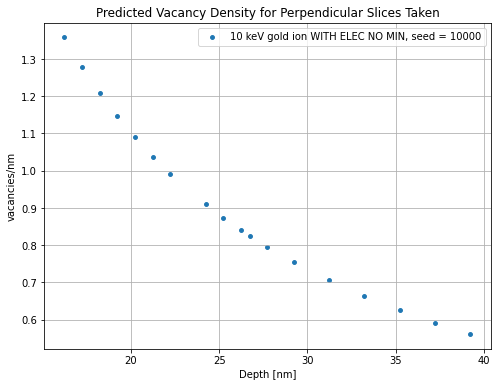

In [11]:
plt.figure(figsize=(8, 6))

y_values1, y_values2 = [y_start1 - y for y in y_end_options], [y_start2 - y for y in y_end_options]
y_values3, y_values4, y_values5 = [y_start3 - y for y in y_end_options], [y_start4 - y for y in y_end_options], [y_start5 - y for y in y_end_options]

# plt.scatter(y_values1, result1, label = f'10 keV gold ion NO ELEC, seed = {seeds[0]}', s = 15)
# plt.scatter(y_values_elec_1, result_elec_1, label = f'10 keV gold ion WITH ELEC, seed = {seeds[0]}', s = 15)

# plt.scatter(y_values2, result2, label = f'10 keV gold ion NO ELEC, seed = {seeds[1]}', s = 15)
# plt.scatter(y_values_elec_2, result_elec_2, label = f'10 keV gold ion WITH ELEC, seed = {seeds[1]}', s = 15)

# plt.scatter(y_values3, result3, label = f'10 keV gold ion NO ELEC, seed = {seeds[2]}', s = 15)
# plt.scatter(y_values_elec_3, result_elec_3, label = f'10 keV gold ion WITH ELEC, seed = {seeds[2]}', s = 15)

# plt.scatter(y_values4, result4, label = f'10 keV gold ion NO ELEC, seed = {seeds[3]}', s = 15)
# plt.scatter(y_values_elec_4, result_elec_4, label = f'10 keV gold ion WITH ELEC, seed = {seeds[3]}', s = 15)

plt.scatter(y_values5, result5, label = f'10 keV gold ion WITH ELEC NO MIN, seed = {seeds[4]}', s = 15)

plt.title(f'Predicted Vacancy Density for Perpendicular Slices Taken')
plt.xlabel('Depth [nm]')
plt.ylabel('vacancies/nm')
plt.legend(loc = 'best')
plt.grid(True)

### Step 7: Subtract the displaced atoms from the original configuration to visualize what the created track would more realistically look like!

In [12]:
'''

Just like the header says, we're subtracting out the intersticial atoms to give the resulting cube without the tracks inside. 
This will give a better visualization of understanding the track length and width visually and compares moreso with the tracks we are actually
irradiating and measuring. 

#note: the cell will probably take a few minutes depending on how large the lattice is that was loaded in because there are many hundreds of 
thousands of atoms that need to be plotted (vs a few hundred/thousand intersticial atoms).

Note to self: this doesn't actually show the track very well. you would need to zoom in a lot more in all directions to the range of damage just
because there are so many atoms. 

'''

"\n\nJust like the header says, we're subtracting out the intersticial atoms to give the resulting cube without the tracks inside. \nThis will give a better visualization of understanding the track length and width visually and compares moreso with the tracks we are actually\nirradiating and measuring. \n\n#note: the cell will probably take a few minutes depending on how large the lattice is that was loaded in because there are many hundreds of \nthousands of atoms that need to be plotted (vs a few hundred/thousand intersticial atoms).\n\nNote to self: this doesn't actually show the track very well. you would need to zoom in a lot more in all directions to the range of damage just\nbecause there are so many atoms. \n\n"

In [13]:
#load in the dataframes of the original crystals after minimization and temperature settling 
######################################################################################################################

original_crystal1, original_crystal2 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_50000_original', sep = " "), pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_43613_original', sep = " ")
original_crystal3, original_crystal4 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_40000_original', sep = " "), pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_15000_original', sep = " ")
original_crystal5 = pd.read_csv('5_25_2025_runs/5_25_2025_gold_silicon_original', sep = " ")

data1ids, data2ids, data3ids, data4ids, data5ids = data_1['id'].values, data_2['id'].values, data_3['id'].values, data_4['id'].values, data_5['id'].values 
og1ids, og2ids = original_crystal1['id'].values, original_crystal2['id'].values
og3ids, og4ids, og5ids = original_crystal3['id'].values, original_crystal4['id'].values, original_crystal5['id'].values

data_1_mods, data_2_mods = np.setdiff1d(og1ids, data1ids), np.setdiff1d(og2ids, data2ids) #find the ids found in both
data_3_mods, data_4_mods, data_5_mods = np.setdiff1d(og3ids, data3ids), np.setdiff1d(og4ids, data4ids), np.setdiff1d(og5ids, data5ids)

data_1_mod, data_2_mod = original_crystal1[original_crystal1['id'].isin(data_1_mods)], original_crystal2[original_crystal2['id'].isin(data_2_mods)]
data_3_mod, data_4_mod = original_crystal3[original_crystal3['id'].isin(data_3_mods)], original_crystal4[original_crystal4['id'].isin(data_4_mods)]
data_5_mod = original_crystal5[original_crystal5['id'].isin(data_5_mods)]

vacancies_1, vacancies_2 = original_crystal1[original_crystal1['id'].isin(data1ids)], original_crystal2[original_crystal2['id'].isin(data2ids)]
vacancies_3, vacancies_4 = original_crystal3[original_crystal3['id'].isin(data3ids)], original_crystal4[original_crystal4['id'].isin(data4ids)]
vacancies_5 = original_crystal5[original_crystal5['id'].isin(data5ids)]

######################################################################################################################

data_1_mod.loc[:, 'x'], data_2_mod.loc[:, 'x'] = data_1_mod['x'] / 10, data_2_mod['x'] / 10
data_1_mod.loc[:, 'y'], data_2_mod.loc[:, 'y'] = data_1_mod['y'] / 10, data_2_mod['y'] / 10
data_1_mod.loc[:, 'z'], data_2_mod.loc[:, 'z'] = data_1_mod['z'] / 10, data_2_mod['z'] / 10

data_3_mod.loc[:, 'x'], data_4_mod.loc[:, 'x'] = data_3_mod['x'] / 10, data_4_mod['x'] / 10
data_3_mod.loc[:, 'y'], data_4_mod.loc[:, 'y'] = data_3_mod['y'] / 10, data_4_mod['y'] / 10
data_3_mod.loc[:, 'z'], data_4_mod.loc[:, 'z'] = data_3_mod['z'] / 10, data_4_mod['z'] / 10

data_5_mod.loc[:, 'x'] = data_5_mod['x'] / 10
data_5_mod.loc[:, 'y'] = data_5_mod['y'] / 10
data_5_mod.loc[:, 'z'] = data_5_mod['z'] / 10

vacancies_1.loc[:, 'x'], vacancies_2.loc[:, 'x'] = vacancies_1['x'] / 10, vacancies_2['x'] / 10
vacancies_1.loc[:, 'y'], vacancies_2.loc[:, 'y'] = vacancies_1['y'] / 10, vacancies_2['y'] / 10
vacancies_1.loc[:, 'z'], vacancies_2.loc[:, 'z'] = vacancies_1['z'] / 10, vacancies_2['z'] / 10

vacancies_3.loc[:, 'x'], vacancies_4.loc[:, 'x'] = vacancies_3['x'] / 10, vacancies_4['x'] / 10
vacancies_3.loc[:, 'y'], vacancies_4.loc[:, 'y'] = vacancies_3['y'] / 10, vacancies_4['y'] / 10
vacancies_3.loc[:, 'z'], vacancies_4.loc[:, 'z'] = vacancies_3['z'] / 10, vacancies_4['z'] / 10

vacancies_5.loc[:, 'x'] = vacancies_5['x'] / 10
vacancies_5.loc[:, 'y'] = vacancies_5['y'] / 10
vacancies_5.loc[:, 'z'] = vacancies_5['z'] / 10

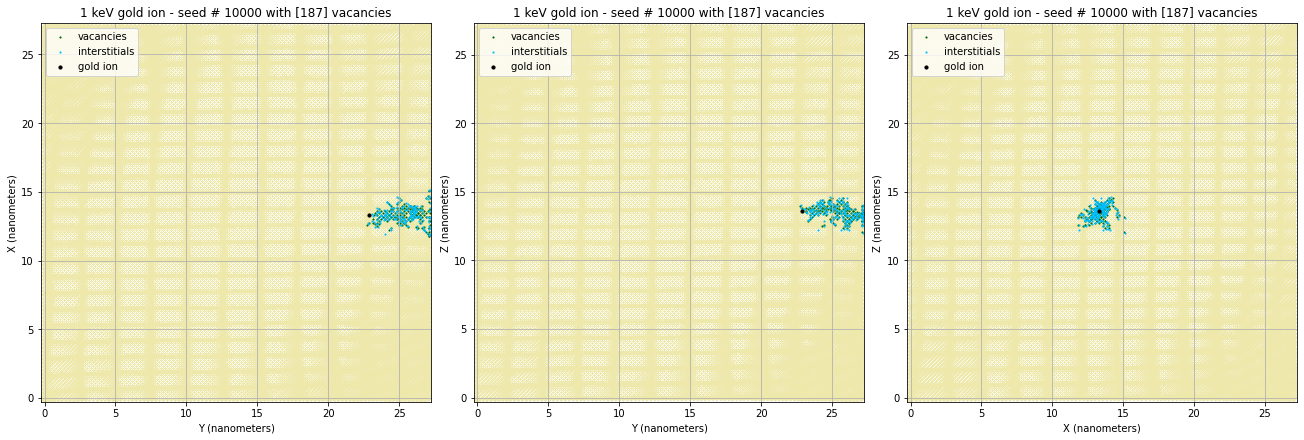

In [14]:
# visualize the resulting damage similar to above
mod_data = [data_1_mod, data_2_mod, data_3_mod, data_4_mod, data_5_mod]
vacancies = [vacancies_1, vacancies_2, vacancies_3, vacancies_4, vacancies_5]
original_data = [data_1, data_2, data_3, data_4, data_5]
num_vacancies = [num_vacancies1, num_vacancies2, num_vacancies3, num_vacancies4, num_vacancies5]

x_min = min(df['x'].min() for df in mod_data)
x_max = max(df['x'].max() for df in mod_data)
y_min = min(df['y'].min() for df in mod_data)
y_max = max(df['y'].max() for df in mod_data)
z_min = min(df['z'].min() for df in mod_data)
z_max = max(df['z'].max() for df in mod_data)

######################################################################################

def plot_damage(ax, mod, vac, orig, seed, num_vac, axis1, axis2, axis_labels, limits, title_suffix=""):
    ax.scatter(mod[axis1], mod[axis2], s=1, marker='.', color='palegoldenrod', alpha=0.45)
    ax.scatter(vac[axis1], vac[axis2], s=5, marker='.', color='darkgreen', label='vacancies')
    ax.scatter(orig[axis1], orig[axis2], s=5, marker='.', color='deepskyblue', label='interstitials')
    ax.scatter(orig[orig['type'] == gold_type][axis1], orig[orig['type'] == gold_type][axis2], s=40, color='black', marker='.', label='gold ion')
    ax.set_title(f'1 keV gold ion - seed # {seed} with {num_vac} vacancies{title_suffix}')
    ax.set_xlabel(f"{axis_labels[0]} (nanometers)")
    ax.set_ylabel(f"{axis_labels[1]} (nanometers)")
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.set_xlim(*limits[axis1])
    ax.set_ylim(*limits[axis2])

######################################################################################    

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
dataframe = 5

x_min, x_max = data_5_mod['x'].min(), data_5_mod['x'].max()
y_min, y_max = data_5_mod['y'].min(), data_5_mod['y'].max()
z_min, z_max = data_5_mod['z'].min(), data_5_mod['z'].max()

limits = {'x': (x_min, x_max), 'y': (y_min, y_max), 'z': (z_min, z_max)}
axis_pairs = [('y', 'x'), ('y', 'z'), ('x', 'z')]
axis_labels = {'x': 'X', 'y': 'Y','z': 'Z'}

for idx, (axis1, axis2) in enumerate(axis_pairs):
    plot_damage(ax = axes[idx], mod = mod_data[dataframe - 1], vac = vacancies[dataframe - 1], orig = original_data[dataframe - 1],
        seed = seeds[dataframe - 1], num_vac = num_vacancies[dataframe - 1], axis1 = axis1, axis2 = axis2,
        axis_labels = (axis_labels[axis1], axis_labels[axis2]), limits = limits)

### Step 8: Analyze the statistics when executing the same simulation multiple times.

In [15]:
def analyze_stats(n, *inputs):
    """
    This function takes in an integer n that corresponds to the number of dataframes inputted, 
    and various inputs starting with all of the inputted dataframes and following with desired 
    other inputs such as the saved track lengths in the previous cell. The function then analyzes 
    the statistics of these inputs and computes the mean, median, variance, and standard deviation 
    values for all inputs loaded in.

    ORDER OF STATS PRINTED:
    1) Vacancy information - first load in dataframes
    2) Total damage track depths - second load in track depth information
    3) Gold track depth - third load in gold track depth information
    """

    print(f"Processing {n} runs")

    vacancy_counts, tot_tracks, gold_tracks = [], [], []

    dfs = inputs[:n]
    #tot_track = inputs[n:2*n]
    #gold_track = inputs[2*n:3*n]

    for i, df in enumerate(dfs):
        print(f"DataFrame {i+1} shape: {df.shape}")  

        # grab number of vacancies from each dataframe
        first_step = df['step'].iloc[0]
        num_vacancies = len(df[df['step'] == first_step])
        print(f"Run {i+1} had {num_vacancies} total vacancies")
        vacancy_counts.append(num_vacancies)

    # find stats on the vacancies
    mean_val = np.mean(vacancy_counts)
    median_val = np.median(vacancy_counts)
    variance_val = np.var(vacancy_counts)  
    std_dev_val = np.std(vacancy_counts) 

    print(f"\nSummary statistics across {n} runs with different seeds:")
    print(f"Mean # of vacancies: {mean_val}")
    print(f"Median # of vacancies: {median_val}")
    print(f"Variance: {variance_val:.1f}; STD: {std_dev_val:.1f}\n")

   # for j in range(n):
   #     track_val = np.array(tot_track[j]).item()  # Get scalar from single-item list
   #     print(f"Run {j+1} had a total damage track length of {track_val:.4f} nm.")
   #     tot_tracks.append(track_val)

   # print(f"\nSummary statistics for track lengths across runs with different seeds:")
   # print(f"Mean: {np.mean(tot_tracks):.2f}; Median: {np.median(tot_tracks):.2f}")
   # print(f"Variance: {np.var(tot_tracks):.2f}; STD: {np.std(tot_tracks):.2f}\n")

   # for k in range(n):
   #     gold_val = np.array(gold_track[k]).item()  # Get scalar from single-item list
   #     print(f"Run {k+1} had the gold ion travel {gold_val:.4f} nm.")
   #     gold_tracks.append(gold_val)

    #print(f"\nSummary statistics for distance gold traveled across runs with different seeds:")
    #print(f"Mean: {np.mean(gold_tracks):.2f}; Median: {np.median(gold_tracks):.2f}")
    #print(f"Variance: {np.var(gold_tracks):.2f}; STD: {np.std(gold_tracks):.2f}")


In [16]:
num_dfs = 5
analyze_stats(num_dfs, data_1, data_2, data_3, data_4, data_5)

Processing 5 runs
DataFrame 1 shape: (1243, 7)
Run 1 had 1243 total vacancies
DataFrame 2 shape: (1323, 7)
Run 2 had 1323 total vacancies
DataFrame 3 shape: (1271, 7)
Run 3 had 1271 total vacancies
DataFrame 4 shape: (1306, 7)
Run 4 had 1306 total vacancies
DataFrame 5 shape: (187, 7)
Run 5 had 187 total vacancies

Summary statistics across 5 runs with different seeds:
Mean # of vacancies: 1066.0
Median # of vacancies: 1271.0
Variance: 193928.8; STD: 440.4



### Step 9: Calculate the track width and length.

In [17]:
'''

this is divided into multiple parts. first we need to define a gaussian function for each depth input with a certain thickness
that counts the number of interstitials and vacancy sites in said thickness slice -> think something like the following
num_vac = np.sum(data['y'] > depth - tol + data['y'] < depth + tol)

then towards the beginning plot the density of vacancies as a function of gaussian radius, this should look gaussian. from this plot we need
to define a threshold at what point do we define the width to be - then in the future use this threshold to automatically stop the function from 
continuing to grow and recalculate and simply move on.

for each depth, the recorded width will be saved and this process is repeated increasing the depth further into the crystal sample until 
at some point we reach a threshold and the track has concluded

**** this is a work in progress ****


'''

"\n\nthis is divided into multiple parts. first we need to define a gaussian function for each depth input with a certain thickness\nthat counts the number of interstitials and vacancy sites in said thickness slice -> think something like the following\nnum_vac = np.sum(data['y'] > depth - tol + data['y'] < depth + tol)\n\nthen towards the beginning plot the density of vacancies as a function of gaussian radius, this should look gaussian. from this plot we need\nto define a threshold at what point do we define the width to be - then in the future use this threshold to automatically stop the function from \ncontinuing to grow and recalculate and simply move on.\n\nfor each depth, the recorded width will be saved and this process is repeated increasing the depth further into the crystal sample until \nat some point we reach a threshold and the track has concluded\n\n**** this is a work in progress ****\n\n\n"

In [22]:
tolerance = 0.1
def gaussian_circ(a, b, origin, radius):
    a = np.asarray(a)
    b = np.asarray(b)
    dist_sq = (a - origin[0])**2 + (b - origin[1])**2
    r_sq = radius**2

    mask = np.abs(dist_sq - r_sq) <= tolerance
    points = np.column_stack((a[mask], b[mask]))

    return points

origin = (13, 13)
end_radius = 5
radii = np.linspace(0, end_radius, 501)  
delta = 0.5 
depth_tol = tolerance 
target_depth_y = 26
dataframe = 5

# Grab the appropriate data
data, vac = data_list[dataframe - 1], vacancies[dataframe - 1]

# Select atoms in the y-plane range (tolerance applied here)
plane_vac = vac[np.abs(vac['y'] - target_depth_y) <= depth_tol]
x_coords_vac, z_coords_vac = plane_vac['x'].values, plane_vac['z'].values

plane_int = data[np.abs(data['y'] - target_depth_y) <= depth_tol]
x_coords_int, z_coords_int = plane_int['x'].values, plane_int['z'].values

# Main loop
results = []

for r in radii:
    count_vac_total, count_int_total = 0, 0

    for dr in [-delta, 0, delta]:
        r_adj = r + dr
        vac_points_found = gaussian_circ(x_coords_vac, z_coords_vac, origin, r_adj)
        int_points_found = gaussian_circ(x_coords_int, z_coords_int, origin, r_adj)

        count_vac_total += len(vac_points_found)
        count_int_total += len(int_points_found)

    avg_vac = count_vac_total / 3
    avg_int = count_int_total / 3

    if avg_vac == 0 and avg_int == 0: #checking for a solid ending point 
        zero_streak += 1
        if zero_streak < 3:
            continue  # skip appending while streak < 10 zeros
    else:
        zero_streak = 0  # reset streak when non-zero found

    results.append({
        'radius': r,
        'avg_vacancies': avg_vac,
        'avg_interstitials': avg_int
    })

radii = [d['radius'] for d in results]
avg_vac = [d['avg_vacancies'] for d in results]
avg_int = [d['avg_interstitials'] for d in results]

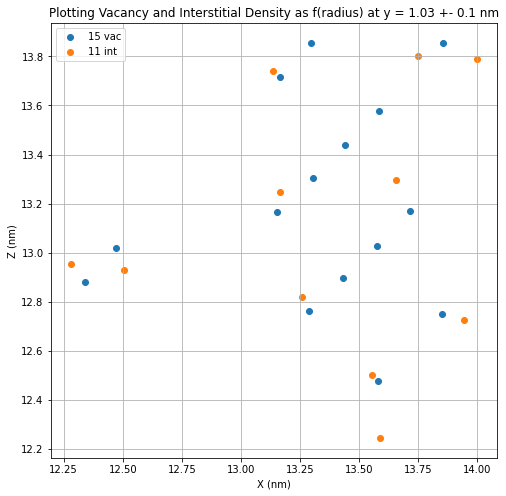

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))  # create figure and axes properly

target_depth_y = 26.24

# Select atoms in the y-plane range (tolerance applied here)
plane_vac = vac[np.abs(vac['y'] - target_depth_y) <= depth_tol]
x_coords_vac, z_coords_vac = plane_vac['x'].values, plane_vac['z'].values

plane_int = data[np.abs(data['y'] - target_depth_y) <= depth_tol]
x_coords_int, z_coords_int = plane_int['x'].values, plane_int['z'].values

plt.scatter(x_coords_vac, z_coords_vac, label = f'{len(x_coords_vac)} vac')
plt.scatter(x_coords_int, z_coords_int, label = f'{len(x_coords_int)} int')


plt.title(f'Plotting Vacancy and Interstitial Density as f(radius) at y = {(y_max - target_depth_y):.2f} +- {depth_tol} nm')
plt.xlabel('X (nm)')
plt.ylabel('Z (nm)')
plt.legend(loc = 'best')
plt.grid(True)

In [32]:
'''

ok now we have the density part, the widest part of the track is going to be where the density of vac/int is highest 

so we need to loop this over multiple depths until the answer is completely 0 for the densities (that means there is no damage detected) 
and identify the slice with the highest density and print out its approximate radius 

'''
all_results = {}  # To store results keyed by depth
max_density = 0
max_info = {'depth': None, 'radius': None}

target_depths = np.linspace(22, 30, 1001)

for i in target_depths:
    plane_vac = vac[np.abs(vac['y'] - i) <= depth_tol]
    x_coords_vac, z_coords_vac = plane_vac['x'].values, plane_vac['z'].values

    plane_int = data[np.abs(data['y'] - i) <= depth_tol]
    x_coords_int, z_coords_int = plane_int['x'].values, plane_int['z'].values

    results = []
    zero_streak = 0

    for r in radii: #start iterating over increasing radius size
        count_vac_total, count_int_total = 0, 0

        for dr in [-delta, 0, delta]:
            r_adj = r + dr
            vac_points_found = gaussian_circ(x_coords_vac, z_coords_vac, origin, r_adj)
            int_points_found = gaussian_circ(x_coords_int, z_coords_int, origin, r_adj)

            count_vac_total += len(vac_points_found)
            count_int_total += len(int_points_found)

        avg_vac = count_vac_total / 3
        avg_int = count_int_total / 3

        if avg_vac == 0 and avg_int == 0:
            zero_streak += 1
            if zero_streak >= 10:
                break  # Exit the radius loop if 10 zeros in a row
            continue
        else:
            zero_streak = 0

        results.append({
            'radius': r,
            'avg_vacancies': avg_vac,
            'avg_interstitials': avg_int
        })

        # Check and update max density
        total_density = avg_vac + avg_int
        if total_density > max_density:
            max_density = total_density
            max_info = {'depth': i, 'radius': r}

    if results:
        all_results[i] = results

Maximum density of damage occurs at depth y ≈ 0.91 nm with a maximum track width of ≈ 1.57 nm.
The distance the 1keV gold ion traveled into Silicon is 4.50 nm.


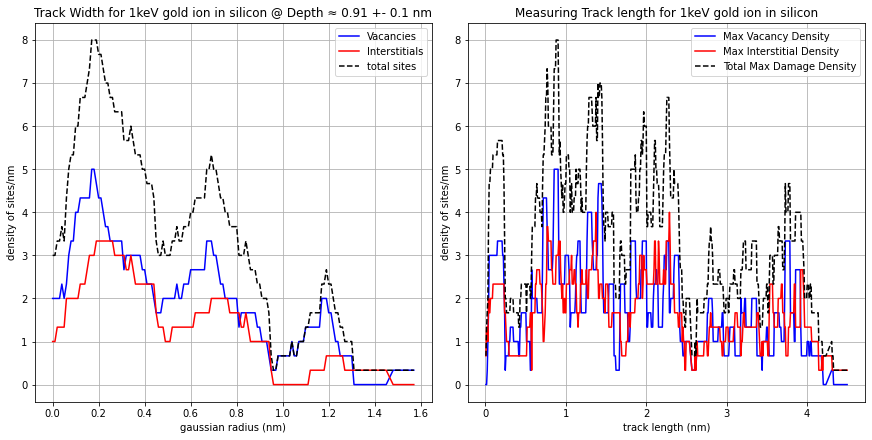

In [ ]:
#information to calculate the largest radius and at what slice in sample
best_depth = max_info['depth']
best_results = all_results[best_depth]
radii_best = [d['radius'] for d in best_results]
vac_best = [d['avg_vacancies'] for d in best_results]
int_best = [d['avg_interstitials'] for d in best_results]
total_best = [v + i for v, i in zip(vac_best, int_best)]


#information to calculate the track length
depths = []
max_vac_densities = []
max_int_densities = []
max_total_densities = []

for depth, results in all_results.items():
    max_entry = max(results, key=lambda d: d['avg_vacancies'] + d['avg_interstitials'])
    
    depths.append(depth)
    max_vac_densities.append(max_entry['avg_vacancies'])
    max_int_densities.append(max_entry['avg_interstitials'])
    max_total_densities.append(max_entry['avg_vacancies'] + max_entry['avg_interstitials'])

depths = [y_max - depth for depth in depths]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)



axes[0].plot(radii_best, vac_best, label='Vacancies', color = 'blue')
axes[0].plot(radii_best, int_best, label='Interstitials', color = 'red')
axes[0].plot(radii_best, total_best, label = 'total sites', color = 'black', linestyle = '--')
axes[0].set_title(f'Track Width for 1keV gold ion in silicon @ Depth ≈ {(y_max - best_depth):.2f} +- {depth_tol} nm')
axes[0].set_xlabel('gaussian radius (nm)')
axes[0].set_ylabel('density of sites/nm')
axes[0].legend(loc = 'best')
axes[0].grid(True)

axes[1].plot(depths, max_vac_densities, label = 'Max Vacancy Density', color = 'blue')
axes[1].plot(depths, max_int_densities, label = 'Max Interstitial Density', color = 'red')
axes[1].plot(depths, max_total_densities, label = 'Total Max Damage Density', color = 'black', linestyle = '--')
axes[1].set_title(f'Measuring Track length for 1keV gold ion in silicon')
axes[1].set_xlabel('track length (nm)')
axes[1].set_ylabel('density of sites/nm')
axes[1].legend(loc = 'best')
axes[1].grid(True)

print(f"Maximum density of damage occurs at depth y ≈ {(y_max - max_info['depth']):.2f} nm with a maximum track width of ≈ {max(radii_best)} nm.")
print(f"The distance the 1keV gold ion traveled into Silicon is {max(depths):.2f} nm.")

In [26]:
'''

now make the track depth vs width plot for selected slices and add in the respective error bars 

for horizontal error bars, this is only due to the depth tolerance we allow that matches how the TEM takes images so there is nothing to propagate

for vertical error bars, the depth tolerance and also the threshold of the gaussian sphere both have impacts so we need to propagate those together

'''

depth_options = np.arange(23.25, 27.25, 0.25)


all_results = {}  # To store results keyed by depth
max_density = 0
max_info = {'depth': None, 'radius': None}

for i in depth_options:
    plane_vac = vac[np.abs(vac['y'] - i) <= depth_tol]
    x_coords_vac, z_coords_vac = plane_vac['x'].values, plane_vac['z'].values

    plane_int = data[np.abs(data['y'] - i) <= depth_tol]
    x_coords_int, z_coords_int = plane_int['x'].values, plane_int['z'].values

    results = []
    zero_streak = 0

    for r in radii: #start iterating over increasing radius size
        count_vac_total, count_int_total, count_tot_total = 0, 0, 0
        vac_points_all, int_points_all, tot_points_all = [], [], []

        for dr in [-delta, 0, delta]:
            r_adj = r + dr
            vac_points_found = gaussian_circ(x_coords_vac, z_coords_vac, origin, r_adj)
            int_points_found = gaussian_circ(x_coords_int, z_coords_int, origin, r_adj)
            arrays_to_stack = [a for a in [int_points_found, vac_points_found] if len(a) > 0]
            if arrays_to_stack:
                tot_points_found = np.vstack(arrays_to_stack)
                gauss_thresh, delta_thresh = 0.1, 0.01
                N0 = len(gaussian_circ(x_coords_vac, z_coords_vac, origin, r_adj))
                N_plus = len(gaussian_circ(x_coords_vac, z_coords_vac, origin, r_adj))
                N_minus = len(gaussian_circ(x_coords_vac, z_coords_vac, origin, r_adj))
            else:
                tot_points_found = np.empty((0, 2))  


            count_vac_total += len(vac_points_found)
            count_int_total += len(int_points_found)
            count_tot_total += len(tot_points_found)

            vac_points_all.append(len(vac_points_found))
            int_points_all.append(len(int_points_found))
            tot_points_all.append(len(tot_points_found))

        avg_vac = count_vac_total / 3
        avg_int = count_int_total / 3
        avg_tot = (count_vac_total + count_int_total) / 3

        std_vac = np.std(vac_points_all, ddof = 1)
        std_int = np.std(int_points_all, ddof = 1)
        std_tot = np.std(tot_points_all, ddof = 1)

        if avg_vac == 0 and avg_int == 0:
            zero_streak += 1
            if zero_streak >= 10:
                break  # Exit the radius loop if 10 zeros in a row
            continue
        else:
            zero_streak = 0

        results.append({
            'radius': r,
            'avg_vacancies': avg_vac,
            'avg_interstitials': avg_int,
            'avg_totalpoints': avg_tot,
            'std_vacancies': std_vac,
            'std_interstitials': std_int,
            'std_totalpoints': std_tot
        })

        # Check and update max density
        total_density = avg_vac + avg_int
        if total_density > max_density:
            max_density = total_density
            max_info = {'depth': i, 'radius': r}

    if results:
        all_results[i] = results

In [27]:
depths, max_radii, vac_vest, int_best, total_best, std_total, std_threshold = [], [], [], [], [], [], []

for depth in depth_options:
    results = all_results.get(depth, [])
    if not results:
        continue
    last_entry = results[-1] 

    depths.append(depth)
    max_radii.append(last_entry['radius']) #grabbing last radius value for each depth to get max radius before it becomes non-zero

    std_total.append(last_entry['std_totalpoints'])
    #std_threshold.append(last_entry['std_tolerance'])

    # vac_best.append(last_entry['avg_vacancies'])
    # int_best.append(last_entry['avg_interstitials'])
    # total_best.append(last_entry['avg_vacancies'] + last_entry['avg_interstitials'])

depths = [y_max - depth for depth in depth_options]


'''
calculate error propagation for the vertical error bars -> depends on both depth_tol and tolerance value in gaussian calculation

'''

def error_prop(sigma1, sigma2):
    sigma1 = np.asarray(sigma1)
    sigma2 = np.asarray(sigma2)
    return np.sqrt(sigma1**2 + sigma2**2)


#y_error_bars = error_prop(std_total, std_threshold)

print(std_total)


[np.float64(1.1547005383792517), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(1.1547005383792517), np.float64(0.5773502691896258)]


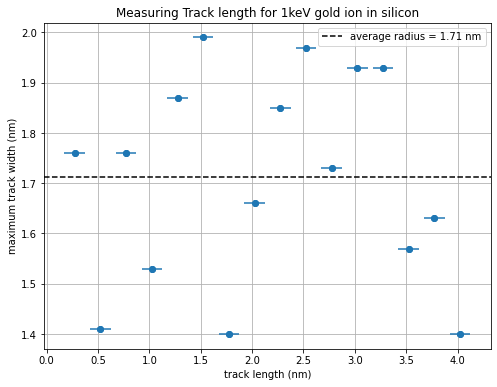

In [28]:
overall_average = np.mean(max_radii)

fig, ax = plt.subplots(figsize=(8, 6))  # create figure and axes properly

plt.scatter(depths, max_radii)
plt.errorbar(depths, max_radii, xerr = depth_tol, fmt='o')
plt.axhline(y = overall_average, color = 'black', linestyle = '--', label = f'average radius = {overall_average:.2f} nm')
#plt.errorbar(depths, max_radii, yerr = y_error_bars, fmt='o')
plt.title(f'Measuring Track length for 1keV gold ion in silicon')
plt.xlabel('track length (nm)')
plt.ylabel('maximum track width (nm)')
plt.legend(loc = 'best')
plt.grid(True)